# Tardiness

- Tardiness = 0, wenn der Auftrag rechtzeitig oder sogar vorzeitig fertiggestellt wurde.
- Tardiness > 0, wenn der Auftrag später fertiggestellt wird als ursprünglich vorgesehen
- berücksichtigt nur positive Abweichungen, also nur tatsächliche Verspätungen.

$$
T_j = \max(0,\; C_j - d_j)
$$


- $T_j$: Tardiness (Verspätung) des Jobs $j$  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $T_j > 0$: Job ist **verspätet**  
- $T_j = 0$: Job ist **pünktlich oder zu früh**  
- Frühfertigungen werden **nicht bestraft**, sondern zu $0$ gesetzt

In [4]:
max_time = 60 * 60 # 1 h

In [5]:
import time

In [6]:
import math
import pulp
import pandas as pd

pd.set_option('display.max_rows', 11)

In [7]:
import utils.presenter as show
import utils.checker as check

import utils.rolling_planning.init_jobs_times as rp_init
import utils.schedule_deadline as deadline_gen

In [8]:
import utils.scheduling_solver as ssv

In [9]:
df_instance= pd.read_csv("data/00_instance.csv")

df_jssp, df_arrivals = rp_init.init_jobs_with_arrivals(df_instance, 1, u_b_mmax= 0.9)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
185,Job_018,5,M9,76
186,Job_018,6,M5,47
187,Job_018,7,M3,52
188,Job_018,8,M4,90


In [10]:
df_arrivals

,Job,Arrival
0,Job_000,0.00
1,Job_001,88.05
2,Job_002,152.78
3,Job_003,207.97
4,Job_004,246.61
...,...,...
14,Job_014,1190.89
15,Job_015,1197.28
16,Job_016,1198.72
17,Job_017,1324.04


In [11]:
df_times = deadline_gen.get_times_df(df_jssp, df_arrivals, ssv.schedule_fcfs_with_arrivals, target_service=1.0)
df_times

,Job,Arrival,Deadline
0,Job_000,0.00,891.122012
1,Job_001,88.05,1238.612598
2,Job_002,152.78,1434.190893
3,Job_003,207.97,1685.653337
4,Job_004,246.61,1133.220002
...,...,...,...
14,Job_014,1190.89,2668.573337
15,Job_015,1197.28,2083.890002
16,Job_016,1198.72,2480.130893
17,Job_017,1324.04,2215.162012


## a) Summe der Tardiness minimieren

$$
\min \; \sum_{j \in J} \max(0,\; C_j - d_j)
$$


- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\max(0,\; C_j - d_j)$: Tardiness von Job $j$  
- Die Summe betrachtet **nur verspätete Jobs** – Frühfertigungen zählen nicht.

**Erklärung:**  
Diese Zielfunktion minimiert die **Gesamtheit aller Verspätungen**, d. h. die Summe aller positiven Abweichungen von den Deadlines.

In [14]:
import pandas as pd
import pulp
import math

def solve_jssp_sum_tardiness(df_jssp: pd.DataFrame, df_arrivals_deadlines: pd.DataFrame, solver: str = 'HiGHS', 
                             epsilon: float = 0.0, sort_ascending: bool = False, **solver_args) -> pd.DataFrame:
    """
    Minimiert die Summe der Tardiness (Verspätungen) aller Jobs.
    Zielfunktion: sum_j [ max(0, Endzeit_j - Deadline_j) ]

    Parameter:
    - df_jssp: DataFrame mit ['Job','Operation','Machine','Processing Time'].
    - df_arrivals_deadlines: DataFrame mit ['Job','Arrival','Deadline'].
    - solver: 'CBC' oder 'HiGHS' (case-insensitive).
    - epsilon: Pufferzeit zwischen Operationen auf derselben Maschine.
    - sort_ascending: Sortiert Jobs nach Deadline.
    - **solver_args: Weitere Solver-Parameter wie msg=True, timeLimit=1200 etc.

    Rückgabe:
    - DataFrame mit ['Job','Operation','Arrival','Deadline','Machine',
      'Start','Processing Time','End','Tardiness'].
    """

    # 1. Vorverarbeitung
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # BigM berechnen (Worst Case)
    sum_proc_time = df_jssp["Processing Time"].sum()
    min_arrival = min(arrival.values())
    max_deadline = max(deadline.values())
    num_machines = df_jssp["Machine"].nunique()

    bigM_raw = max_deadline - min_arrival + sum_proc_time / math.sqrt(num_machines)
    bigM = math.ceil(bigM_raw / 1000) * 1000
    print(f"BigM: {bigM}")

    # 2. Operationen je Job
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = row["Operation"]
            m = str(row["Machine"])
            d = float(row["Processing Time"])
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    n = len(jobs)

    # 3. Modell
    prob = pulp.LpProblem("JSSP_SumTardiness", pulp.LpMinimize)

    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=arrival[jobs[j]])
        for j in range(n)
        for o in range(len(all_ops[j]))
    }

    ends = {
        j: pulp.LpVariable(f"end_{j}", lowBound=arrival[jobs[j]])
        for j in range(n)
    }

    tard = {
        j: pulp.LpVariable(f"tardiness_{j}", lowBound=0)
        for j in range(n)
    }

    # 4. Zielfunktion
    prob += pulp.lpSum(tard[j] for j in range(n))

    # 5. Technologische Reihenfolge & Tardiness
    for j, job in enumerate(jobs):
        seq = all_ops[j]
        for o in range(1, len(seq)):
            d_prev = seq[o - 1][2]
            prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev
        d_last = seq[-1][2]
        prob += ends[j] == starts[(j, len(seq) - 1)] + d_last
        prob += tard[j] >= ends[j] - deadline[job]

    # 6. Maschinenkonflikte
    for m in machines:
        ops_on_m = [
            (j, o, seq[o][2])
            for j, seq in enumerate(all_ops)
            for o in range(len(seq))
            if seq[o][1] == m
        ]
        for i in range(len(ops_on_m)):
            j1, o1, d1 = ops_on_m[i]
            for j2, o2, d2 in ops_on_m[i + 1:]:
                if j1 == j2:
                    continue
                y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM * (1 - y)
                prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM * y

    # 7. Solverwahl
    solver_args.setdefault("msg", True)
    solver = solver.upper()
    if solver == "HIGHS":
        cmd = pulp.HiGHS_CMD(**solver_args)
    elif solver == "CBC":
        cmd = pulp.PULP_CBC_CMD(**solver_args)
    else:
        raise ValueError("Solver must be 'CBC' or 'HiGHS'")
    
    prob.solve(cmd)
    objective_value = pulp.value(prob.objective)

    # 8. Ergebnisse
    records = []
    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            st = starts[(j, o)].varValue
            ed = st + d
            records.append({
                "Job": job,
                "Operation": op_id,
                "Arrival": arrival[job],
                "Deadline": deadline[job],
                "Machine": m,
                "Start": round(st, 2),
                "Processing Time": d,
                "End": round(ed, 2),
                "Tardiness": max(0, round(ed - deadline[job], 2))
            })

    df_schedule = (
        pd.DataFrame.from_records(records)
        .sort_values(["Start", "Job", "Operation"])
        .reset_index(drop=True)
    )

    # 9. Logging
    print("\nSolver-Informationen:")
    print(f"  Summe Tardiness         : {round(objective_value, 4)}")
    print(f"  Solver-Status           : {pulp.LpStatus[prob.status]}")
    print(f"  Anzahl Variablen        : {len(prob.variables())}")
    print(f"  Anzahl Constraints      : {len(prob.constraints)}")

    return df_schedule


In [15]:
starting_time = time.time()

# Scheduling
df_plan_sum_t = solve_jssp_sum_tardiness(df_jssp, df_times, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.01)

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan_sum_t

BigM: 6000

Solver-Informationen:
  Summe Tardiness         : 0.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 1938
  Anzahl Constraints      : 3629

Scheduling-Dauer: 4 Minuten und 47.98 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_000,0,0.00,891.122012,M0,0.00,29.0,29.00,0
1,Job_000,1,0.00,891.122012,M1,29.00,78.0,107.00,0
2,Job_001,0,88.05,1238.612598,M0,88.05,43.0,131.05,0
3,Job_000,2,0.00,891.122012,M2,107.00,9.0,116.00,0
4,Job_000,3,0.00,891.122012,M3,116.00,36.0,152.00,0
...,...,...,...,...,...,...,...,...,...
185,Job_016,9,1198.72,2480.130893,M4,2447.13,33.0,2480.13,0
186,Job_018,9,1429.61,2647.852751,M7,2482.61,45.0,2527.61,0
187,Job_014,7,1190.89,2668.573337,M3,2505.57,98.0,2603.57,0
188,Job_014,8,1190.89,2668.573337,M9,2603.57,22.0,2625.57,0


In [16]:
show.count_column_grouped(df_plan_sum_t, 'Tardiness')

<0             0
0            190
0-30           0
30-60          0
60-120         0
120-240        0
240-480        0
480-720        0
720-1440       0
1440-2880      0
>2880          0
dtype: int32

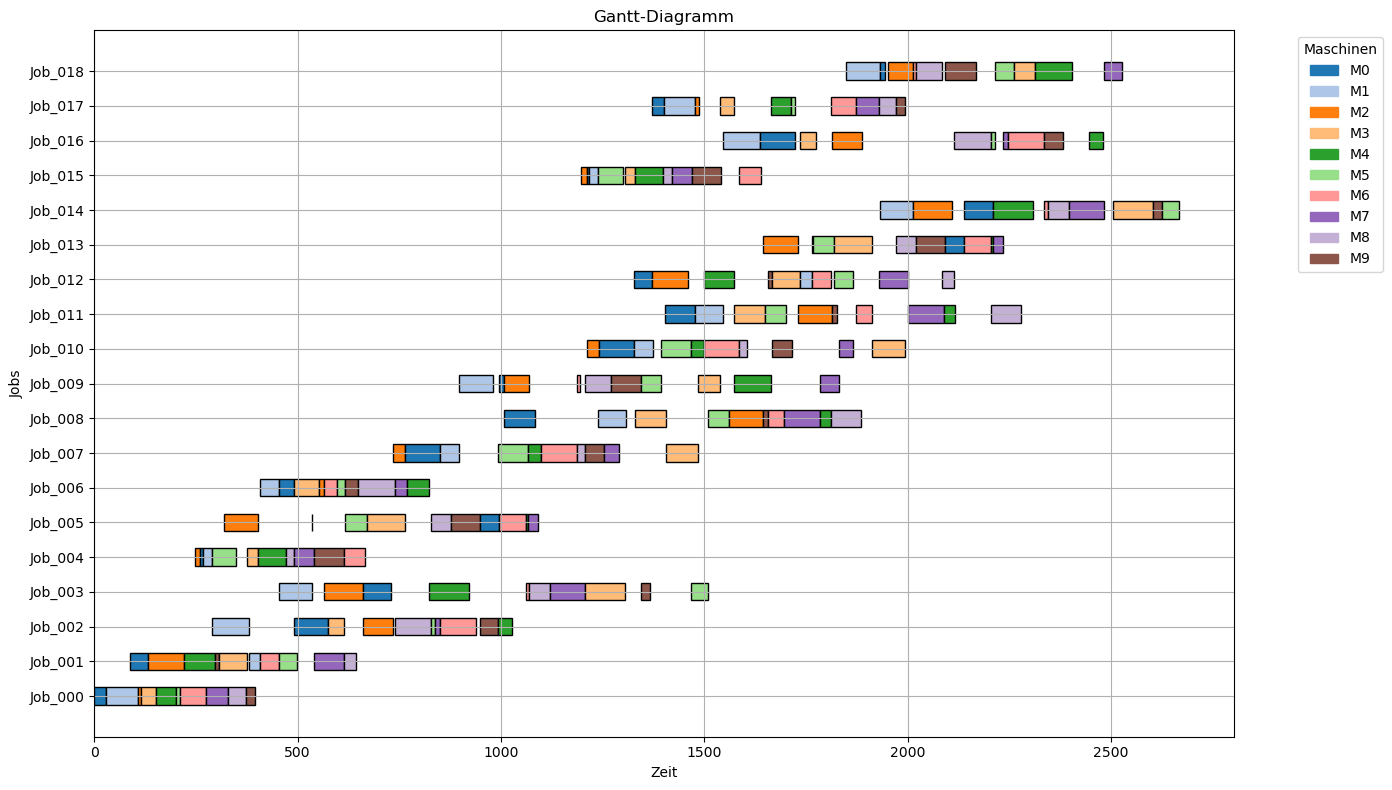

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [17]:
df_plan = df_plan_sum_t

show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

## b) größte Tardiness minimieren

$$
\min \; \max_{j \in J} \left( \max(0,\; C_j - d_j) \right)
$$


- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\max(0,\; C_j - d_j)$: Tardiness des Jobs $j$  
- Die äußere $\max$-Funktion bestimmt den Job mit der **größten Verspätung**

**Erklärung:**  
Diese Zielfunktion minimiert die **schlimmste Deadline-Überschreitung** unter allen Jobs. Frühfertigungen fließen dabei **nicht** ein.


In [20]:
import pandas as pd
import pulp
import math

def solve_jssp_max_tardiness(df_jssp: pd.DataFrame, df_arrivals_deadlines: pd.DataFrame, solver: str = 'HiGHS', 
                             epsilon: float = 0.0, sort_ascending: bool = False, **solver_args) -> pd.DataFrame:
    """
    Minimiert die maximale Tardiness (Verspätung) unter allen Jobs.
    Zielfunktion: max_j [ max(0, Endzeit_j - Deadline_j) ]

    Parameter:
    - df_jssp: DataFrame mit ['Job','Operation','Machine','Processing Time'].
    - df_arrivals_deadlines: DataFrame mit ['Job','Arrival','Deadline'].
    - solver: 'CBC' oder 'HiGHS' (case-insensitive).
    - epsilon: Pufferzeit zwischen Operationen auf derselben Maschine.
    - sort_ascending: Sortiert die Jobs nach Deadline.
    - **solver_args: Weitere Solver-Parameter wie msg=True, timeLimit=1200 etc.

    Rückgabe:
    - DataFrame mit ['Job','Operation','Arrival','Deadline','Machine',
      'Start','Processing Time','End','Tardiness'].
    """

    # 1. Vorverarbeitung
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # BigM berechnen (Worst Case)
    sum_proc_time = df_jssp["Processing Time"].sum()
    min_arrival = min(arrival.values())
    max_deadline = max(deadline.values())
    num_machines = df_jssp["Machine"].nunique()
    
    bigM_raw = max_deadline - min_arrival + sum_proc_time / math.sqrt(num_machines)
    bigM = math.ceil(bigM_raw / 1000) * 1000
    print(f"BigM: {bigM}")

    # 2. Operationen je Job
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = row["Operation"]
            m = str(row["Machine"])
            d = float(row["Processing Time"])
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    n = len(jobs)

    # 3. LP-Modell
    prob = pulp.LpProblem("JSSP_MaxTardiness", pulp.LpMinimize)

    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=arrival[jobs[j]])
        for j in range(n)
        for o in range(len(all_ops[j]))
    }

    ends = {
        j: pulp.LpVariable(f"end_{j}", lowBound=arrival[jobs[j]])
        for j in range(n)
    }

    tard = {
        j: pulp.LpVariable(f"tardiness_{j}", lowBound=0)
        for j in range(n)
    }

    max_tard = pulp.LpVariable("max_tardiness", lowBound=0)

    # Zielfunktion
    prob += max_tard

    # 4. Technologische Reihenfolge & Tardiness
    for j, job in enumerate(jobs):
        seq = all_ops[j]
        for o in range(1, len(seq)):
            d_prev = seq[o - 1][2]
            prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev
        d_last = seq[-1][2]
        prob += ends[j] == starts[(j, len(seq) - 1)] + d_last
        prob += tard[j] >= ends[j] - deadline[job]
        prob += max_tard >= tard[j]

    # 5. Maschinenkonflikte
    for m in machines:
        ops_on_m = [
            (j, o, seq[o][2])
            for j, seq in enumerate(all_ops)
            for o in range(len(seq))
            if seq[o][1] == m
        ]
        for i in range(len(ops_on_m)):
            j1, o1, d1 = ops_on_m[i]
            for j2, o2, d2 in ops_on_m[i + 1:]:
                if j1 == j2:
                    continue
                y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM * (1 - y)
                prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM * y

    # 6. Solverwahl
    solver_args.setdefault("msg", True)
    solver = solver.upper()
    if solver == "HIGHS":
        cmd = pulp.HiGHS_CMD(**solver_args)
    elif solver == "CBC":
        cmd = pulp.PULP_CBC_CMD(**solver_args)
    else:
        raise ValueError("Solver must be 'CBC' or 'HiGHS'")

    prob.solve(cmd)
    objective_value = pulp.value(prob.objective)

    # 7. Ergebnis extrahieren
    records = []
    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            st = starts[(j, o)].varValue
            ed = st + d
            records.append({
                "Job": job,
                "Operation": op_id,
                "Arrival": arrival[job],
                "Deadline": deadline[job],
                "Machine": m,
                "Start": round(st, 2),
                "Processing Time": d,
                "End": round(ed, 2),
                "Tardiness": max(0, round(ed - deadline[job], 2))
            })

    df_schedule = (
        pd.DataFrame.from_records(records)
        .sort_values(["Start", "Job", "Operation"])
        .reset_index(drop=True)
    )

    # 8. Logging
    print("\nSolver-Informationen:")
    print(f"  Maximale Tardiness      : {round(objective_value, 4)}")
    print(f"  Solver-Status           : {pulp.LpStatus[prob.status]}")
    print(f"  Anzahl Variablen        : {len(prob.variables())}")
    print(f"  Anzahl Constraints      : {len(prob.constraints)}")

    return df_schedule


In [21]:
starting_time = time.time()

# Scheduling
df_plan_max_t = solve_jssp_max_tardiness(df_jssp, df_times, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.01)

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan_max_t

BigM: 6000

Solver-Informationen:
  Maximale Tardiness      : 0.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 1939
  Anzahl Constraints      : 3648

Scheduling-Dauer: 0 Minuten und 42.45 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_000,0,0.00,891.122012,M0,0.00,29.0,29.00,0
1,Job_000,1,0.00,891.122012,M1,29.00,78.0,107.00,0
2,Job_001,0,88.05,1238.612598,M0,88.05,43.0,131.05,0
3,Job_000,2,0.00,891.122012,M2,107.00,9.0,116.00,0
4,Job_000,3,0.00,891.122012,M3,116.00,36.0,152.00,0
...,...,...,...,...,...,...,...,...,...
185,Job_014,7,1190.89,2668.573337,M3,2505.57,98.0,2603.57,0
186,Job_018,8,1429.61,2647.852751,M4,2505.57,90.0,2595.57,0
187,Job_018,9,1429.61,2647.852751,M7,2602.85,45.0,2647.85,0
188,Job_014,8,1190.89,2668.573337,M9,2603.57,22.0,2625.57,0


In [22]:
show.count_column_grouped(df_plan_max_t, 'Tardiness')

<0             0
0            190
0-30           0
30-60          0
60-120         0
120-240        0
240-480        0
480-720        0
720-1440       0
1440-2880      0
>2880          0
dtype: int32

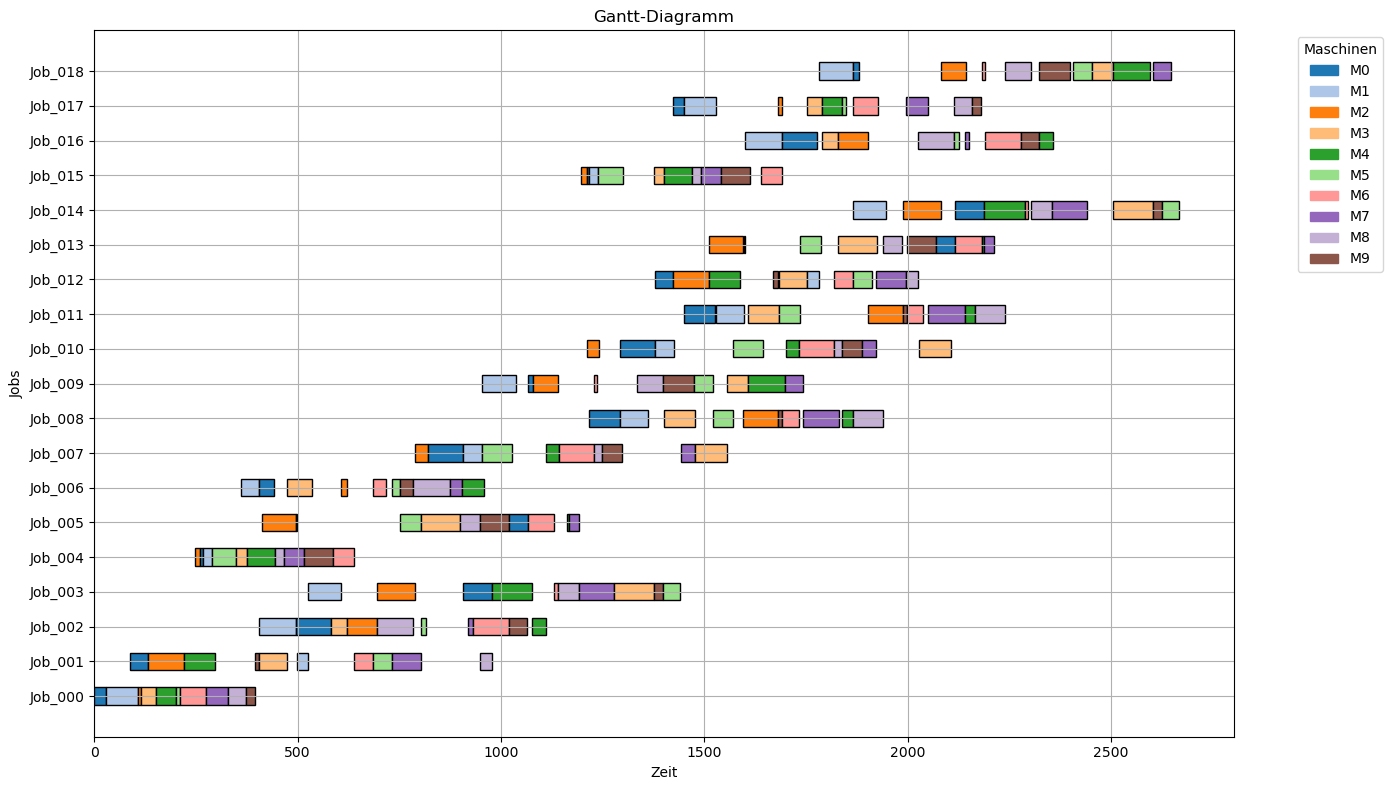

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [23]:
df_plan = df_plan_max_t

show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)